In [19]:
import torch
import torch.nn as nn
from utils import get_emnist_dataset, binarize_dataset, show_samples, get_emnist_test_dataset, load_emnist_images, load_emnist_labels, fix_emnist_rotation
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np

In [2]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando GPU (Metal)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando GPU (Metal)


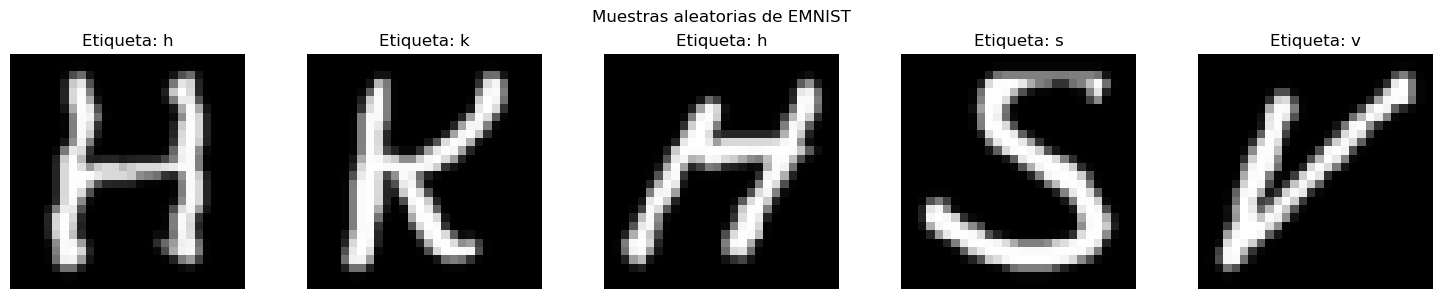

In [3]:
data, labels = get_emnist_dataset()
data = data / 255
show_samples(data, labels, 5)

In [4]:
data.shape

(124800, 28, 28)

In [5]:
# data = data / 255

# data = binarize_dataset(data)

# show_samples(data, labels, 5)

In [6]:
X_tensor = torch.tensor(data, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)

X_tensor = X_tensor.view(X_tensor.shape[0], -1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for batch_X, batch_y in dataloader:
    print(batch_X.shape, batch_y.shape)  # (64, 784) (64,)
    break

torch.Size([64, 784]) torch.Size([64])


In [7]:
# just_a_data = data[labels == 1]
# just_a_labels = labels[labels == 1]

In [8]:
# ax_tensor = torch.tensor(just_a_data, dtype=torch.float32)
# ay_tensor = torch.tensor(just_a_labels, dtype=torch.long)

# ax_tensor = ax_tensor.view(ax_tensor.shape[0], -1)

# dataset_a = TensorDataset(ax_tensor, ay_tensor)
# dataloader_a = DataLoader(dataset_a, batch_size=64, shuffle=True)

In [9]:
class RBM(nn.Module):
    def __init__(self, visible_units=784, hidden_units=1024, k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.k = k

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h, sample_h

    def h_to_v(self, h):
        p_v = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v, sample_v
    
    def forward(self, v):
        # Paso 1: "Starting with a data vector on the visible units, update all of the hidden units in parallel"
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            # Paso 2: "Update all of the visible units in parallel to get a 'reconstruction'"
            pre_v_,v_ = self.h_to_v(h_)
            # Paso 3: "Update all of the hidden units again"
            pre_h_,h_ = self.v_to_h(v_)

        return v, v_

    def free_energy(self, v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [10]:
rbm = RBM(k=1).to(device)
optimizer = optim.SGD(rbm.parameters(),0.05)

In [11]:
num_epochs = 20

for epoch in range(num_epochs):
    losses = []
    for _, (data, target) in enumerate(dataloader):
        data = Variable(data.to(device))
        sample_data = data.bernoulli()

        v, v1 = rbm(data)

        # Usar contrastive divergence (CD)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(losses)))

Training loss for 0 epoch: -5.360421925080129
Training loss for 1 epoch: -2.6542111127804486
Training loss for 2 epoch: -1.2990017621945111
Training loss for 3 epoch: -0.7068142934945914
Training loss for 4 epoch: -0.41235221667167465
Training loss for 5 epoch: -0.17640690730168268
Training loss for 6 epoch: -0.05403833633814103
Training loss for 7 epoch: 0.05914405235877404
Training loss for 8 epoch: 0.2005240728916266
Training loss for 9 epoch: 0.28442498622796475
Training loss for 10 epoch: 0.37803091195913463
Training loss for 11 epoch: 0.39722820575420675
Training loss for 12 epoch: 0.5204822872846554
Training loss for 13 epoch: 0.5281894155649038
Training loss for 14 epoch: 0.581221423026843
Training loss for 15 epoch: 0.6197790370843349
Training loss for 16 epoch: 0.6605713516626602
Training loss for 17 epoch: 0.7457176325871394
Training loss for 18 epoch: 0.7324000744941908
Training loss for 19 epoch: 0.7864104442107371


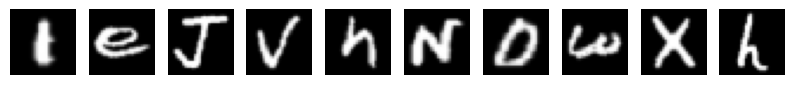

In [15]:
v_sample = v.cpu().detach().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(v_sample[i], cmap="gray")
    ax.axis("off")
plt.show()

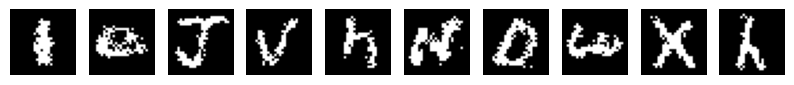

In [16]:
v1_sample = v1.cpu().detach().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(v1_sample[i], cmap="gray")
    ax.axis("off")
plt.show()

In [22]:
def get_emnist_test_dataset():
    images = load_emnist_images('data/EMNIST/raw/emnist-letters-test-images-idx3-ubyte')
    labels = load_emnist_labels('data/EMNIST/raw/emnist-letters-test-labels-idx1-ubyte')

    images = fix_emnist_rotation(images)

    return images, labels

In [23]:
test_data, test_labels = get_emnist_test_dataset()
test_data = test_data / 255
X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], -1)
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

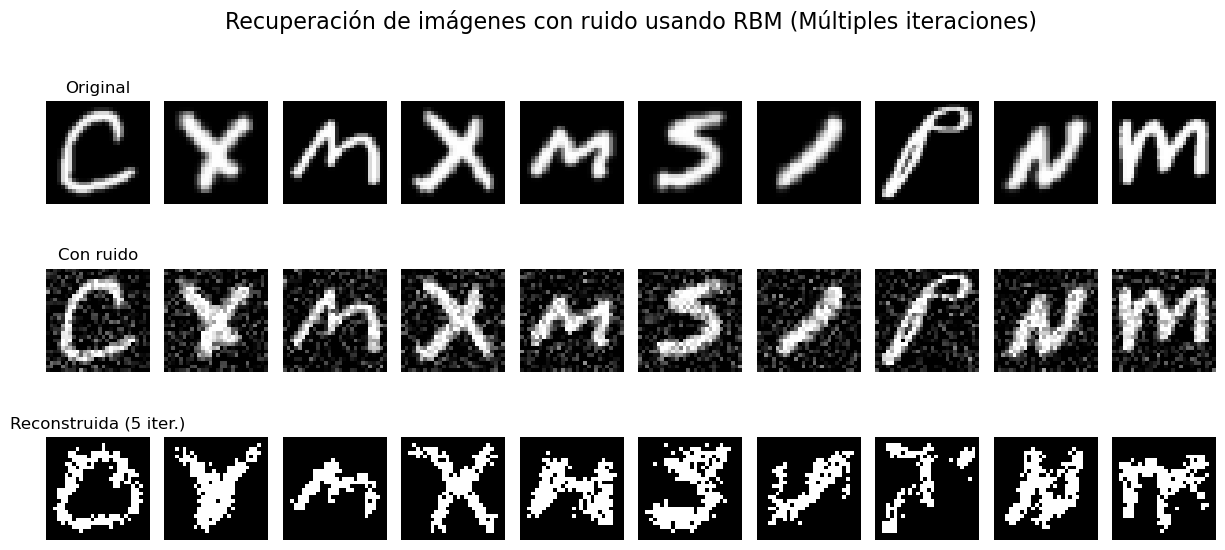

Error cuadrático medio de reconstrucción después de 5 iteraciones: 0.1124


In [25]:
# Seleccionar algunas instancias de entrenamiento aleatoriamente
n_samples = 10
# Obtener un lote completo de datos
full_batch = next(iter(dataloader_test))[0]
# Seleccionar índices aleatorios
random_indices = torch.randperm(len(full_batch))[:n_samples]
test_data = full_batch[random_indices].to(device)
original_data = test_data.clone()

# Añadir ruido a los datos (usando ruido gaussiano)
noise_factor = 0.2
noisy_data = test_data + noise_factor * torch.randn_like(test_data)
noisy_data = torch.clamp(noisy_data, 0., 1.)  # Asegurar que los valores estén entre 0 y 1

# Reconstruir los datos con la RBM usando múltiples iteraciones
n_iterations = 5  # Número de iteraciones para la reconstrucción
reconstructed_data = noisy_data.clone()

with torch.no_grad():
    for _ in range(n_iterations):
        _, reconstructed_data = rbm(reconstructed_data)

# Visualizar los resultados
fig, axes = plt.subplots(3, n_samples, figsize=(12, 6))
plt.suptitle('Recuperación de imágenes con ruido usando RBM (Múltiples iteraciones)', fontsize=16)

# Mostrar imágenes originales
for i in range(n_samples):
    axes[0, i].imshow(original_data[i].cpu().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=12)

# Mostrar imágenes con ruido
for i in range(n_samples):
    axes[1, i].imshow(noisy_data[i].cpu().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Con ruido', fontsize=12)

# Mostrar imágenes reconstruidas
for i in range(n_samples):
    axes[2, i].imshow(reconstructed_data[i].cpu().reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title(f'Reconstruida ({n_iterations} iter.)', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Calcular el error de reconstrucción
mse = torch.mean((original_data - reconstructed_data) ** 2).item()
print(f"Error cuadrático medio de reconstrucción después de {n_iterations} iteraciones: {mse:.4f}")
